In [2]:
import matplotlib.pyplot as plt
from matplotlib import rcParams,rc
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import numpy as np
import xarray as xr
import sys
import os
from ncdf_io import ncdf_io


In [3]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2

In [4]:
base=os.getcwd()

In [5]:
dir1='/Users/joedhsu/Research/Rsync/Data/Mask/ETOPO/NOAA/'
file1='ETOPO1_Ice_c_gmt4.grd'


---

## Read the Topo file 

In [6]:
# ncdf_io(dir1+file1+'.nc')
ds=xr.open_dataset(dir1+file1+'.nc')

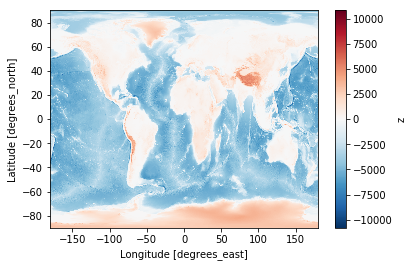

In [7]:
ds['z'].plot()

**Changing the longitude from -180 to 180**

In [8]:
longitude=ds['z'].x.values.copy()   
longitude[np.where(longitude<0)]=longitude[np.where(longitude<0)]+360.
ds['z'].x.values=longitude

---
## Read the Ocean mass 

In [75]:
data1='./data/jpl_mascon_ocean-slf.reg.nc'
data2='./data/jpl_mascon_ocean.reg.nc'
ds_jpl_slfcorr=xr.open_dataset(data1)
ds_jpl=xr.open_dataset(data2)

In [76]:
ds_jpl_slfcorr

<xarray.Dataset>
Dimensions:      (lat: 360, lon: 720, reg_variate: 6)
Coordinates:
  * lon          (lon) float32 0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 ...
  * lat          (lat) float32 -89.75 -89.25 -88.75 -88.25 -87.75 -87.25 ...
  * reg_variate  (reg_variate) |S10 'con' 'lin' 'anncos' 'annsin' ...
Data variables:
    beta         (reg_variate, lat, lon) float64 ...
    se           (reg_variate, lat, lon) float64 ...
    annamp       (lat, lon) float64 ...
    annphase     (lat, lon) float64 ...
    annamperr    (lat, lon) float64 ...
    annphaseerr  (lat, lon) float64 ...

In [77]:
ds_jpl

<xarray.Dataset>
Dimensions:      (lat: 360, lon: 720, reg_variate: 6)
Coordinates:
  * lon          (lon) float32 0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 ...
  * lat          (lat) float32 -89.75 -89.25 -88.75 -88.25 -87.75 -87.25 ...
  * reg_variate  (reg_variate) |S10 'con' 'lin' 'anncos' 'annsin' ...
Data variables:
    beta         (reg_variate, lat, lon) float64 ...
    se           (reg_variate, lat, lon) float64 ...
    annamp       (lat, lon) float64 ...
    annphase     (lat, lon) float64 ...
    annamperr    (lat, lon) float64 ...
    annphaseerr  (lat, lon) float64 ...

**Interpolate the topo to match with the ocean mass data**

In [12]:
ds_topo_interp=ds['z'].interp(coords={'x':ds_jpl_slfcorr.lon, 'y':ds_jpl_slfcorr.lat})

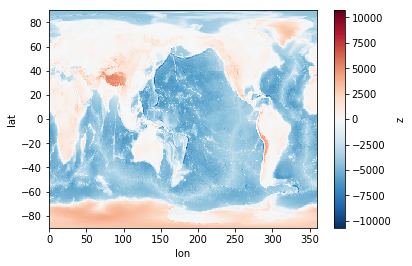

In [13]:
ds_topo_interp.plot()

In [14]:
ds_topo_interp.to_netcdf('./data/topo_interp.nc')

In [15]:
ds_topo_interp=ds_topo_interp.drop(['x','y'])

In [16]:
ds_topo_interp

<xarray.DataArray 'z' (lat: 360, lon: 720)>
array([[ 2747.5 ,  2747.5 ,  2748.  , ...,  2746.  ,  2746.  ,  2746.  ],
       [ 2687.  ,  2688.  ,  2688.  , ...,  2684.  ,  2685.5 ,  2686.  ],
       [ 2661.5 ,  2663.  ,  2665.  , ...,  2656.  ,  2658.  ,  2660.  ],
       ...,
       [-4283.5 , -4285.5 , -4288.75, ..., -4279.  , -4280.  , -4282.  ],
       [-4226.  , -4228.  , -4229.  , ..., -4222.  , -4223.75, -4225.5 ],
       [-4146.  , -4145.75, -4145.5 , ..., -4146.  , -4146.  , -4146.  ]])
Coordinates:
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 -87.75 -87.25 -86.75 ...
  * lon      (lon) float32 0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75 ...
Attributes:
    long_name:     z
    actual_range:  [-10803.   8333.]


---
**Plotting with Projection change**

`ccrs.Orthographic` projection does not seems to work for the interp topo result. Worng topo values (contourf cannot show value lower than -2000)  are shown for the whole map

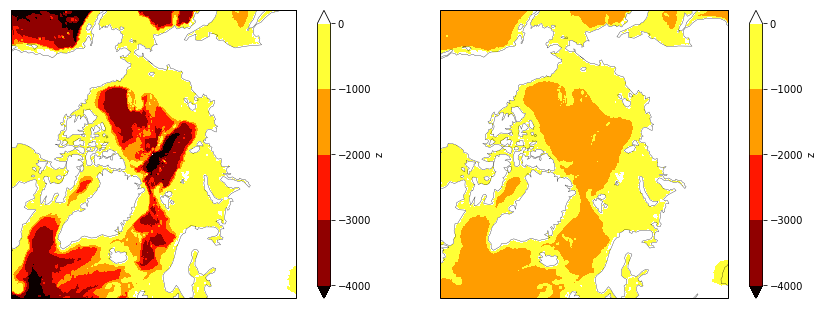

In [17]:
# set the figure and data projection
data_proj=ccrs.PlateCarree()
fig_proj_test=ccrs.Orthographic(0, 90)    # rotating the center of the projection  => Not working for topo
fig_proj=ccrs.NorthPolarStereo(0, 90)    # rotating the center of the projection

# set the figure axes
fig=plt.figure(facecolor='w',edgecolor='w')
ax1=fig.add_axes([0,0,1,1],projection=fig_proj)
ax2=fig.add_axes([1,0,1,1],projection=fig_proj_test)

# plot the data in each axes
ax1.set_title('Topo')
ax1.set_extent([-180,180,57,90], crs=data_proj)
ds_topo_interp.plot.contourf(ax=ax1, transform=data_proj, cmap='hot', levels=np.linspace(-4000,0,5))
ax1.coastlines(resolution='110m',linewidths=0.3)

ax2.set_extent([-180,180,57,90], crs=data_proj)
ds_topo_interp.plot.contourf(ax=ax2, transform=data_proj, cmap='hot', levels=np.linspace(-4000,0,5))
ax2.coastlines(resolution='110m',linewidths=0.3)

---
## Plot the OMASS trend with the topo

In [78]:
from cartopy.util import add_cyclic_point

In [79]:
newdata,newlon=add_cyclic_point(ds_jpl_slfcorr['beta'].sel(reg_variate='lin').values,coord=ds_jpl_slfcorr.lon.values)
jpl_slfcorr_beta_lin_wrap=xr.DataArray(newdata,coords=[ds_jpl_slfcorr.lat.values,newlon],dims=['lat','lon'])
newdata,newlon=add_cyclic_point(ds_jpl['beta'].sel(reg_variate='lin').values,coord=ds_jpl.lon.values)
jpl_beta_lin_wrap=xr.DataArray(newdata,coords=[ds_jpl.lat.values,newlon],dims=['lat','lon'])

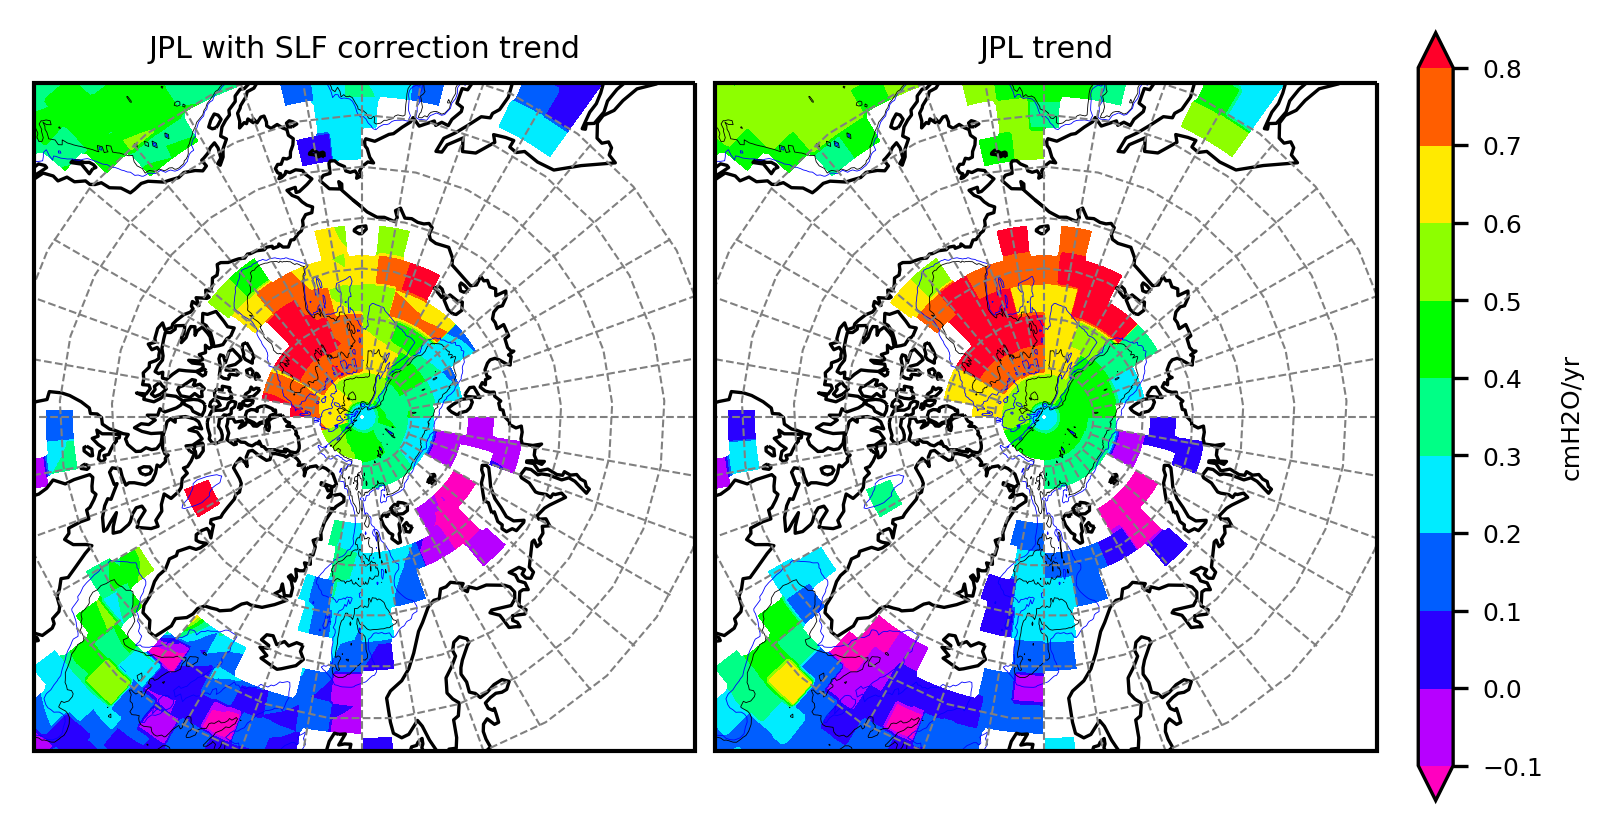

In [80]:
# set the figure and data projection
data_proj=ccrs.PlateCarree()
fig_proj=ccrs.NorthPolarStereo(0, 90)   

# set the figure axes
hmm=70.    # mm
vmm=65.    # mm
fontsize=6
rcParams['xtick.direction'] = 'out'
rcParams['ytick.direction'] = 'out'
rcParams.update({'font.size': fontsize})
rc('font', family='sans-serif')
rc('font', serif='Helvetica')
mm2inch=0.0393701
hmm=hmm*mm2inch
vmm=vmm*mm2inch
fig=plt.figure(figsize=(hmm,vmm),dpi=300,facecolor='w',edgecolor='w')
# ax1=fig.add_axes([0.35,0.0,1.20,1],projection=fig_proj)
# ax2=fig.add_axes([1.2,0,1,1],projection=fig_proj)
ax1=fig.add_axes([0.25,0.065,1.05,0.87],projection=fig_proj)
ax2=fig.add_axes([1.2,0,1,1],projection=fig_proj)

# plot the data in each axes
levels=np.linspace(-0.1,0.8,10)
plot1=jpl_slfcorr_beta_lin_wrap.plot.contourf(ax=ax1, transform=data_proj
        , levels=levels,cmap='gist_rainbow_r',add_colorbar=False, add_labels=True)
ds_topo_interp.plot.contour(ax=ax1, transform=data_proj
                            , colors='k', levels=[-3000],linewidths=0.2,linestyles='solid')
ds_topo_interp.plot.contour(ax=ax1, transform=data_proj
                            , colors='b', levels=[-2000],linewidths=0.2,linestyles='solid')
ax1.set_title('JPL with SLF correction trend')
# ax1.text(fig_proj.transform_point(180,45,data_proj), 'NoSLFcorr')
ax1.set_extent([-180,180,57,90], crs=data_proj)
ax1.coastlines(resolution='110m',linewidths=0.8)


plot2=ds_jpl_beta_lin_wrap.plot.contourf(ax=ax2, transform=data_proj
        , levels=levels, extend='both',cmap='gist_rainbow_r'
        , cbar_kwargs={'ticks': levels,'label':'cmH2O/yr'})
ds_topo_interp.plot.contour(ax=ax2, transform=data_proj
                            , colors='k', levels=[-3000],linewidths=0.2,linestyles='solid')
ds_topo_interp.plot.contour(ax=ax2, transform=data_proj
                            , colors='b', levels=[-2000],linewidths=0.2,linestyles='solid')
ax2.set_title('JPL trend')
ax2.set_extent([-180,180,57,90], crs=data_proj)
ax2.coastlines(resolution='110m',linewidths=0.8)


####################  Grid on  ######################
# *must* call draw in order to get the axis boundary used to add ticks:
fig.canvas.draw()
xtick=np.linspace(0,360,37)-180.  # need to be -180~180
ytick=np.linspace(55,85,7)

#Label the end-points of the gridlines using the custom tick makers:
ax1.gridlines(xlocs=xtick, ylocs=ytick,color='gray', linestyle='--', linewidth=0.5)
ax1.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax1.yaxis.set_major_formatter(LATITUDE_FORMATTER)
# lambert_xticks(ax1, xtick)
# lambert_yticks(ax1, ytick)
ax2.gridlines(xlocs=xtick, ylocs=ytick,color='gray', linestyle='--', linewidth=0.5)
ax2.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax2.yaxis.set_major_formatter(LATITUDE_FORMATTER)



In [81]:
# export the figure
fig.savefig('./figures/arctic_topo_overlap_omass.pdf', dpi=300, facecolor='w', edgecolor='w',
        orientation='landscape', papertype=None, format=None,
        transparent=False, bbox_inches="tight", pad_inches=None,
        frameon=None)


## Based on the figure above 
* Try the pressure head calculation and see if the correction of SLF change the time series
* The gradient change in the Pacific side above 1000 m 
* Is the meridional transport at each layer can help decompose the Sverdrup balance
* A comparison of the current with the ECCOv4 output is needed
---

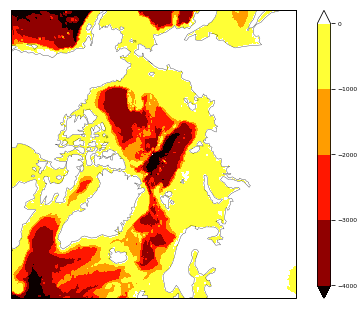

In [82]:
newdata,newlon=add_cyclic_point(ds_topo_interp.values,coord=ds_topo_interp.lon.values)
ds_topo_interp_wrap=xr.DataArray(newdata,coords=[ds_topo_interp.lat.values,newlon],dims=['lat','lon'])
ds_topo_interp_wrap

# set the figure and data projection
data_proj=ccrs.PlateCarree()
fig_proj_test=ccrs.Orthographic(0, 90)    # rotating the center of the projection  => Not working for topo
fig_proj=ccrs.NorthPolarStereo(0, 90)    # rotating the center of the projection

# set the figure axes
fig=plt.figure(facecolor='w',edgecolor='w')
ax1=fig.add_axes([0,0,1,1],projection=fig_proj)
# plot the data in each axes
ax1.set_title('Topo')
ax1.set_extent([-180,180,57,90], crs=data_proj)
plot1=ds_topo_interp_wrap.plot.contourf(ax=ax1, transform=data_proj, cmap='hot', levels=np.linspace(-4000,0,5))
ax1.coastlines(resolution='110m',linewidths=0.3)

# export the figure
fig.savefig('./figures/arctic_topo.pdf', dpi=300, facecolor='w', edgecolor='w',
        orientation='landscape', papertype=None, format=None,
        transparent=False, bbox_inches="tight", pad_inches=None,
        frameon=None)

